# Cumulative event counter

### This notebook counts the cumulative spatio-temporal distribution of cellular events in the local neighbourhood of a series of apoptosis events

1. Load dictionary of ~apoptoses~ events and their corresponding times to base the spatiotemporal scans around 
2. Load corresponding tracking data and specify scan parameters
3. Iteratively calculate spatiotemporal distribution of cellular events around apoptoses, saving each distribution out a list of events/cell apperances

In [4]:
import calculate_radial_analysis as calculate
import dataio

import glob
import os
import re
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from natsort import natsorted
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [29]:
def load_radial_df(file_list, R = 600, crop_amount = 20, streamline = True):
    """
    R : int
        Defines the maximum radius of a focal scan in pixels, if this radius leaves the field of view 
        at the time of apoptosis then that focal apoptosis is excluded from the cumulative scan.
        Currently only really makes a difference for post apoptotic times as cell moves around
        before apoptosis so could leave the FOV prior to the xy used as a centoid here
        WIP: make xyt of all focal apoptoses to have stricter exclusion criteria

    crop_amount : int
        Defines the cropping amount necessary to exclude boundary effect cells/divisions from
        the radial scan
    
    streamlined : bool
        If True this returns just the distance from apoptosis and time since apoptosis variables 
        in the data frame. If False then it returns data frame as in the .csv file.
    """
    radial_scan_df = []
    N_focal_cells = 0
    
    ### if R is not provided then do not filter any focal apoptoses
    if not R:
        R = 0
    ### use R to exclude any focal apoptoses that are out of the FOV at the time of apoptosis
    x_range = range(R, 1200 - R)
    y_range = range(R, 1600 - R)
    
    for file in tqdm(file_list):
        apo_t, apo_x, apo_y = [int(re.search('txy_(\d+)_(\d+)_(\d+)', file)[i]) for i in range(1,4)]
        ### check if xy falls within range
        if apo_x in x_range and apo_y in y_range:
            df = pd.read_csv(file, names = ['Cell ID', 'Distance from apoptosis', 'Frame', 'x', 'y'])
            ### tidy up dataframe
            df['Cell ID'] = df['Cell ID'].str.replace('[()]', '')
            df['y'] = df['y'].str.replace('[()]', '')
            df = df.astype(int)
            ### normalise time
            df['Time since apoptosis'] = df['Frame'] - apo_t
            ### eliminate boundary counts
            df = df.loc[(df['x'] >= crop_amount) & (df['x'] <= 1200-crop_amount) & (df['y'] >= crop_amount) & (df['y'] <= 1600-crop_amount)]
            ### remove unnecessary data
            if streamline:
                del df['x'], df['y'], df['Cell ID'], df['Frame']
            radial_scan_df.append(df)
            N_focal_cells +=1
    radial_scan_df = pd.concat(radial_scan_df, axis = 0, ignore_index = True)
    radial_scan_df['Time since apoptosis'] = radial_scan_df['Time since apoptosis']*(4/60)
    radial_scan_df['Distance from apoptosis'] = radial_scan_df['Distance from apoptosis']/3
    print('Number of focal cells included in cumulative scan:', N_focal_cells)

    return radial_scan_df

def render(N_events_df, N_cells_df, bins, t_range, R_max):
    
    t_min = min(t_range)
    t_max = max(t_range)
    N_events_constrained_df = N_events_df.loc[(N_events_df['Time since apoptosis'] >= t_min) & (N_events_df['Time since apoptosis'] <= t_max) & (N_events_df['Distance from apoptosis'] <= R_max)]
    N_cells_constrained_df = N_cells_df.loc[(N_cells_df['Time since apoptosis'] >= t_min) & (N_cells_df['Time since apoptosis'] <= t_max) & (N_cells_df['Distance from apoptosis'] <= R_max)]

    N_events, xedges, yedges, _ = plt.hist2d(N_events_constrained_df['Time since apoptosis'], N_events_constrained_df['Distance from apoptosis'],
                      bins=bins, cmap='Blues')
    plt.clf()
    N_cells, xedges, yedges, _ = plt.hist2d(N_cells_constrained_df['Time since apoptosis'], N_cells_constrained_df['Distance from apoptosis'],
                      bins=bins, cmap='Blues')
    plt.clf()
    
    P_events = N_events/N_cells
    
    return P_events, xedges, yedges, N_events, N_cells

## 1) Event dictionary loader

Specify cell type to filter out unwanted apoptoses, want end result of event_dict that takes the format of :`event_dict = {event_ID:event_time}` 

where `event_ID` takes the format of: `GV{experiment_ID}_Pos{position_ID}_{cell_ID}_{cell_type}` 

For example: 

```
event_dict = {'GV0794_Pos4_393_GFP': '766',
             'GV0794_Pos7_364_GFP': '550',
             'GV0794_Pos7_457_GFP': '805',
             'GV0794_Pos7_369_GFP': '833',
             'GV0794_Pos7_292_GFP': '884',
             'GV0795_Pos4_358_GFP': '628',
             'GV0795_Pos4_18_GFP': '855',
             'GV0795_Pos4_1356_GFP': '992',
             'GV0795_Pos4_359_GFP': '1133',
             'GV0796_Pos4_542_GFP': '581',
             'GV0796_Pos4_1334_GFP': '719',
             'GV0796_Pos4_1586_GFP': '785'}
 ```
 
Function to apoptosis event dictionary from preexisting data store:

`dataio.apoptosis_list_loader(path_to_apop_lists, cell_type)`

Where the `path_to_apop_lists` is the directory containing the apoptosis information and the `cell_type` is either `'Scr'` or `'WT'`.

In [2]:
path_to_apop_lists = '/home/nathan/data/kraken/scr/h2b/giulia/experiment_information/apoptoses/final/all'
event_dict = dataio.apoptosis_list_loader(path_to_apop_lists, 'Scr')
event_dict

{'GV0797_Pos7_14_RFP': '99',
 'GV0797_Pos7_45_RFP': '201',
 'GV0797_Pos7_5_RFP': '254',
 'GV0797_Pos7_146_RFP': '388',
 'GV0797_Pos7_145_RFP': '398',
 'GV0797_Pos7_30_RFP': '393',
 'GV0797_Pos7_106_RFP': '424',
 'GV0797_Pos7_9_RFP': '405',
 'GV0797_Pos7_204_RFP': '487',
 'GV0797_Pos7_105_RFP': '473',
 'GV0797_Pos7_200_RFP': '486',
 'GV0797_Pos7_199_RFP': '625',
 'GV0797_Pos7_208_RFP': '475',
 'GV0797_Pos7_207_RFP': '475',
 'GV0797_Pos7_203_RFP': '516',
 'GV0797_Pos23_31_RFP': '166',
 'GV0797_Pos23_26_RFP': '60',
 'GV0797_Pos23_260_RFP': '235',
 'GV0797_Pos23_125_RFP': '79',
 'GV0797_Pos23_336_RFP': '456',
 'GV0797_Pos23_252_RFP': '207',
 'GV0797_Pos23_301_RFP': '207',
 'GV0797_Pos23_36_RFP': '180',
 'GV0797_Pos23_319_RFP': '556',
 'GV0797_Pos23_556_RFP': '638',
 'GV0798_Pos22_34_RFP': '54',
 'GV0798_Pos22_36_RFP': '125',
 'GV0798_Pos22_37_RFP': '469',
 'GV0798_Pos22_358_RFP': '461',
 'GV0798_Pos22_26_RFP': '761',
 'GV0798_Pos22_696_RFP': '871',
 'GV0798_Pos22_9_RFP': '190',
 'GV0798_Po

In [3]:
### optional parallelisation step
N_focal = len(event_dict)
para_frac_min, para_frac_max = int(0*N_focal), int(0.1*N_focal)  ## ie only do first 1/4 of all apops
delete_list =[]
for i, j in enumerate(event_dict):
    if not para_frac_min <= i< para_frac_max: 
        delete_list.append(j)
for i in delete_list:
    del event_dict[i]
print("Length of modified dict vs original:", len(event_dict), "/", N_focal)

Length of modified dict vs original: 183 / 1839


## 2) Load corresponding cell tracking data and specifiy other parameters

`dataio.hdf5_file_finder(parent_folder_hdf5)` loads a list of all hdf5 files when supplied with the parent directory of all the experiments. This relies on a typical sub-parent directory structure of `'GV****/Pos*/*aligned/HDF/segmented.hdf5'` (aligned folder optional)

In [50]:
### load tracking data
parent_folder_hdf5 = '/home/nathan/data/kraken/scr/h2b/giulia'
hdf5_file_list = dataio.hdf5_file_finder(parent_folder_hdf5)

### specify output path and neighbourhood scan parameters
radius, t_range = 1600, 1600
output_path = f'/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt'
Path(output_path).mkdir(parents=True, exist_ok=True)

In [34]:
calculate.radial_scan('WT', ## 'Scr',
    'DIVIDE', 
    event_dict, 
    hdf5_file_list, 
    radius, 
    t_range, 
   # num_bins, 
    output_path)

1600 1600


  0%|          | 0/156 [00:00<?, ?it/s]

[INFO][2022/03/02 07:47:04 PM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0798/Pos22/Pos22_aligned/HDF/segmented.hdf5...
[INFO][2022/03/02 07:47:04 PM] Loading tracks/obj_type_1


ID GV0798_Pos22_37_RFP
Loading GV0798/Pos22/
Btrack version no.: 0.4.3


[INFO][2022/03/02 07:47:04 PM] Loading objects/obj_type_1 (54200, 5) (44110 filtered: area>=100)
[INFO][2022/03/02 07:47:05 PM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0798/Pos22/Pos22_aligned/HDF/segmented.hdf5
[INFO][2022/03/02 07:47:05 PM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0798/Pos22/Pos22_aligned/HDF/segmented.hdf5...
[INFO][2022/03/02 07:47:05 PM] Loading tracks/obj_type_2
[INFO][2022/03/02 07:47:06 PM] Loading objects/obj_type_2 (43364, 5) (33560 filtered: area>=100)
[INFO][2022/03/02 07:47:07 PM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0798/Pos22/Pos22_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos22/
ID GV0798_Pos22_358_RFP
ID GV0798_Pos22_26_RFP
ID GV0798_Pos22_696_RFP
ID GV0798_Pos22_9_RFP
ID GV0798_Pos22_10_RFP
ID GV0798_Pos22_31_RFP
ID GV0798_Pos22_652_RFP
ID GV0798_Pos22_6_RFP
ID GV0798_Pos22_744_RFP
ID GV0798_Pos22_549_RFP
ID GV0798_Pos22_669_RFP


[INFO][2022/03/02 08:04:10 PM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2022/03/02 08:04:10 PM] Loading tracks/obj_type_1


ID GV0797_Pos21_78_RFP
Loading GV0797/Pos21/
Btrack version no.: 0.4.3


[INFO][2022/03/02 08:04:13 PM] Loading objects/obj_type_1 (211568, 5) (195992 filtered: area>=100)
[INFO][2022/03/02 08:04:18 PM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5
[INFO][2022/03/02 08:04:18 PM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2022/03/02 08:04:18 PM] Loading tracks/obj_type_2
[INFO][2022/03/02 08:04:18 PM] Loading objects/obj_type_2 (26227, 5) (20975 filtered: area>=100)
[INFO][2022/03/02 08:04:19 PM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos21/
ID GV0797_Pos21_54_RFP
ID GV0797_Pos21_55_RFP
ID GV0797_Pos21_83_RFP
ID GV0797_Pos21_302_RFP
ID GV0797_Pos21_22_RFP
ID GV0797_Pos21_335_RFP
ID GV0797_Pos21_334_RFP
ID GV0797_Pos21_35_RFP


[INFO][2022/03/02 08:38:11 PM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0800/Pos16/Pos16_aligned/HDF/segmented.hdf5...
[INFO][2022/03/02 08:38:11 PM] Loading tracks/obj_type_1


ID GV0800_Pos16_15_RFP
Loading GV0800/Pos16/
Btrack version no.: 0.4.3


[INFO][2022/03/02 08:38:15 PM] Loading objects/obj_type_1 (361372, 5) (345214 filtered: area>=100)
[INFO][2022/03/02 08:38:22 PM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0800/Pos16/Pos16_aligned/HDF/segmented.hdf5
[INFO][2022/03/02 08:38:22 PM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0800/Pos16/Pos16_aligned/HDF/segmented.hdf5...
[INFO][2022/03/02 08:38:22 PM] Loading tracks/obj_type_2
[INFO][2022/03/02 08:38:23 PM] Loading objects/obj_type_2 (88705, 5) (75574 filtered: area>=100)
[INFO][2022/03/02 08:38:26 PM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0800/Pos16/Pos16_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos16/
ID GV0800_Pos16_29_RFP
ID GV0800_Pos16_8_RFP
ID GV0800_Pos16_24_RFP
ID GV0800_Pos16_31_RFP
ID GV0800_Pos16_505_RFP
ID GV0800_Pos16_63_RFP
ID GV0800_Pos16_496_RFP
ID GV0800_Pos16_23_RFP
ID GV0800_Pos16_572_RFP
ID GV0800_Pos16_542_RFP
ID GV0800_Pos16_583_RFP
ID GV0800_Pos16_580_RFP
ID GV0800_Pos16_10_RFP
ID GV0800_Pos16_584_RFP
ID GV0800_Pos16_478_RFP
ID GV0800_Pos16_849_RFP
ID GV0800_Pos16_803_RFP
ID GV0800_Pos16_522_RFP
ID GV0800_Pos16_451_RFP
ID GV0800_Pos16_489_RFP
ID GV0800_Pos16_504_RFP
ID GV0800_Pos16_13_RFP
ID GV0800_Pos16_528_RFP
ID GV0800_Pos16_1155_RFP
ID GV0800_Pos16_632_RFP
ID GV0800_Pos16_1044_RFP


[INFO][2022/03/02 11:47:25 PM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0816/Pos13/Pos13_aligned/HDF/segmented.hdf5...
[INFO][2022/03/02 11:47:25 PM] Loading tracks/obj_type_1


ID GV0816_Pos13_37_RFP
Loading GV0816/Pos13/
Btrack version no.: 0.4.3


[INFO][2022/03/02 11:47:27 PM] Loading objects/obj_type_1 (115677, 5) (105175 filtered: area>=100)
[INFO][2022/03/02 11:47:30 PM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0816/Pos13/Pos13_aligned/HDF/segmented.hdf5
[INFO][2022/03/02 11:47:30 PM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0816/Pos13/Pos13_aligned/HDF/segmented.hdf5...
[INFO][2022/03/02 11:47:30 PM] Loading tracks/obj_type_2
[INFO][2022/03/02 11:47:31 PM] Loading objects/obj_type_2 (55169, 5) (45321 filtered: area>=100)
[INFO][2022/03/02 11:47:31 PM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0816/Pos13/Pos13_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0816/Pos13/
ID GV0816_Pos13_53_RFP
ID GV0816_Pos13_57_RFP
ID GV0816_Pos13_45_RFP
ID GV0816_Pos13_43_RFP
ID GV0816_Pos13_415_RFP
ID GV0816_Pos13_478_RFP
ID GV0816_Pos13_635_RFP
ID GV0816_Pos13_679_RFP
ID GV0816_Pos13_42_RFP


[INFO][2022/03/03 12:08:20 AM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0800/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/03/03 12:08:20 AM] Loading tracks/obj_type_1


ID GV0800_Pos5_17_RFP
Loading GV0800/Pos5/
Btrack version no.: 0.4.3


[INFO][2022/03/03 12:08:20 AM] Loading objects/obj_type_1 (39998, 5) (30974 filtered: area>=100)
[INFO][2022/03/03 12:08:21 AM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0800/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2022/03/03 12:08:21 AM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0800/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/03/03 12:08:21 AM] Loading tracks/obj_type_2
[INFO][2022/03/03 12:08:21 AM] Loading objects/obj_type_2 (56244, 5) (41825 filtered: area>=100)
[INFO][2022/03/03 12:08:22 AM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0800/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos5/
ID GV0800_Pos5_35_RFP
ID GV0800_Pos5_155_RFP
ID GV0800_Pos5_240_RFP
ID GV0800_Pos5_293_RFP
ID GV0800_Pos5_239_RFP
ID GV0800_Pos5_461_RFP
ID GV0800_Pos5_453_RFP
ID GV0800_Pos5_381_RFP
ID GV0800_Pos5_542_RFP
ID GV0800_Pos5_415_RFP
ID GV0800_Pos5_16_RFP
ID GV0800_Pos5_435_RFP
ID GV0800_Pos5_25_RFP
ID GV0800_Pos5_246_RFP
ID GV0800_Pos5_425_RFP
ID GV0800_Pos5_447_RFP
ID GV0800_Pos5_496_RFP
ID GV0800_Pos5_723_RFP


[INFO][2022/03/03 12:25:44 AM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0819/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2022/03/03 12:25:44 AM] Loading tracks/obj_type_1


ID GV0819_Pos0_23_RFP
Loading GV0819/Pos0/
Btrack version no.: 0.4.3


[INFO][2022/03/03 12:25:47 AM] Loading objects/obj_type_1 (285723, 5) (262105 filtered: area>=100)
[INFO][2022/03/03 12:25:53 AM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0819/Pos0/Pos0_aligned/HDF/segmented.hdf5
[INFO][2022/03/03 12:25:53 AM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0819/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2022/03/03 12:25:53 AM] Loading tracks/obj_type_2
[INFO][2022/03/03 12:25:54 AM] Loading objects/obj_type_2 (79945, 5) (62473 filtered: area>=100)
[INFO][2022/03/03 12:25:55 AM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0819/Pos0/Pos0_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0819/Pos0/
ID GV0819_Pos0_495_RFP
ID GV0819_Pos0_493_RFP
ID GV0819_Pos0_494_RFP
ID GV0819_Pos0_736_RFP
ID GV0819_Pos0_740_RFP
ID GV0819_Pos0_38_RFP
ID GV0819_Pos0_642_RFP
ID GV0819_Pos0_786_RFP
ID GV0819_Pos0_909_RFP
ID GV0819_Pos0_895_RFP
ID GV0819_Pos0_448_RFP
ID GV0819_Pos0_527_RFP
ID GV0819_Pos0_53_RFP
ID GV0819_Pos0_167_RFP
ID GV0819_Pos0_456_RFP
ID GV0819_Pos0_21_RFP
ID GV0819_Pos0_1366_RFP
ID GV0819_Pos0_1376_RFP
ID GV0819_Pos0_930_RFP
ID GV0819_Pos0_1088_RFP


[INFO][2022/03/03 02:39:58 AM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0795/Pos18/Pos18_aligned/HDF/segmented.hdf5...
[INFO][2022/03/03 02:39:58 AM] Loading tracks/obj_type_1


ID GV0795_Pos18_379_RFP
Loading GV0795/Pos18/
Btrack version no.: 0.4.3


[INFO][2022/03/03 02:39:58 AM] Loading objects/obj_type_1 (41273, 5) (28239 filtered: area>=100)
[INFO][2022/03/03 02:40:00 AM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0795/Pos18/Pos18_aligned/HDF/segmented.hdf5
[INFO][2022/03/03 02:40:00 AM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0795/Pos18/Pos18_aligned/HDF/segmented.hdf5...
[INFO][2022/03/03 02:40:00 AM] Loading tracks/obj_type_2
[INFO][2022/03/03 02:40:00 AM] Loading objects/obj_type_2 (71063, 5) (58416 filtered: area>=100)
[INFO][2022/03/03 02:40:01 AM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0795/Pos18/Pos18_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0795/Pos18/
ID GV0795_Pos18_413_RFP
ID GV0795_Pos18_854_RFP
ID GV0795_Pos18_855_RFP
ID GV0795_Pos18_1179_RFP
ID GV0795_Pos18_409_RFP
ID GV0795_Pos18_684_RFP
ID GV0795_Pos18_802_RFP
ID GV0795_Pos18_46_RFP
ID GV0795_Pos18_521_RFP
ID GV0795_Pos18_3_RFP
ID GV0795_Pos18_715_RFP
ID GV0795_Pos18_28_RFP
ID GV0795_Pos18_12_RFP
ID GV0795_Pos18_19_RFP
ID GV0795_Pos18_728_RFP


[INFO][2022/03/03 02:58:11 AM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0819/Pos1/Pos1_aligned/HDF/segmented.hdf5...
[INFO][2022/03/03 02:58:11 AM] Loading tracks/obj_type_1


ID GV0819_Pos1_30_RFP
Loading GV0819/Pos1/
Btrack version no.: 0.4.3


[INFO][2022/03/03 02:58:14 AM] Loading objects/obj_type_1 (291961, 5) (262012 filtered: area>=100)
[INFO][2022/03/03 02:58:20 AM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0819/Pos1/Pos1_aligned/HDF/segmented.hdf5
[INFO][2022/03/03 02:58:20 AM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0819/Pos1/Pos1_aligned/HDF/segmented.hdf5...
[INFO][2022/03/03 02:58:20 AM] Loading tracks/obj_type_2
[INFO][2022/03/03 02:58:21 AM] Loading objects/obj_type_2 (51130, 5) (42876 filtered: area>=100)
[INFO][2022/03/03 02:58:22 AM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0819/Pos1/Pos1_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0819/Pos1/
ID GV0819_Pos1_37_RFP
ID GV0819_Pos1_382_RFP
ID GV0819_Pos1_16_RFP
ID GV0819_Pos1_374_RFP
ID GV0819_Pos1_434_RFP
ID GV0819_Pos1_24_RFP
ID GV0819_Pos1_470_RFP
ID GV0819_Pos1_504_RFP
ID GV0819_Pos1_503_RFP
ID GV0819_Pos1_240_RFP
ID GV0819_Pos1_360_RFP


[INFO][2022/03/03 04:30:11 AM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0797/Pos18/Pos18_aligned/HDF/segmented.hdf5...
[INFO][2022/03/03 04:30:11 AM] Loading tracks/obj_type_1


ID GV0797_Pos18_46_RFP
Loading GV0797/Pos18/
Btrack version no.: 0.4.3


[INFO][2022/03/03 04:30:14 AM] Loading objects/obj_type_1 (274136, 5) (262171 filtered: area>=100)
[INFO][2022/03/03 04:30:20 AM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0797/Pos18/Pos18_aligned/HDF/segmented.hdf5
[INFO][2022/03/03 04:30:20 AM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0797/Pos18/Pos18_aligned/HDF/segmented.hdf5...
[INFO][2022/03/03 04:30:20 AM] Loading tracks/obj_type_2
[INFO][2022/03/03 04:30:21 AM] Loading objects/obj_type_2 (17638, 5) (13852 filtered: area>=100)
[INFO][2022/03/03 04:30:21 AM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0797/Pos18/Pos18_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos18/
ID GV0797_Pos18_17_RFP
ID GV0797_Pos18_135_RFP
ID GV0797_Pos18_134_RFP
ID GV0797_Pos18_7_RFP
ID GV0797_Pos18_218_RFP
ID GV0797_Pos18_250_RFP


[INFO][2022/03/03 04:54:52 AM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0820/Pos2/Pos2_aligned/HDF/segmented.hdf5...
[INFO][2022/03/03 04:54:52 AM] Loading tracks/obj_type_1


ID GV0820_Pos2_29_RFP
Loading GV0820/Pos2/
Btrack version no.: 0.4.3


[INFO][2022/03/03 04:54:54 AM] Loading objects/obj_type_1 (187834, 5) (174544 filtered: area>=100)
[INFO][2022/03/03 04:54:58 AM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0820/Pos2/Pos2_aligned/HDF/segmented.hdf5
[INFO][2022/03/03 04:54:58 AM] Opening HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0820/Pos2/Pos2_aligned/HDF/segmented.hdf5...
[INFO][2022/03/03 04:54:58 AM] Loading tracks/obj_type_2
[INFO][2022/03/03 04:54:59 AM] Loading objects/obj_type_2 (73959, 5) (62237 filtered: area>=100)
[INFO][2022/03/03 04:55:01 AM] Closing HDF file: /home/nathan/data/kraken/scr/h2b/giulia/GV0820/Pos2/Pos2_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0820/Pos2/
ID GV0820_Pos2_47_RFP
ID GV0820_Pos2_94_RFP
ID GV0820_Pos2_256_RFP
ID GV0820_Pos2_375_RFP
ID GV0820_Pos2_377_RFP
ID GV0820_Pos2_317_RFP
ID GV0820_Pos2_25_RFP
ID GV0820_Pos2_438_RFP
ID GV0820_Pos2_43_RFP
ID GV0820_Pos2_54_RFP
ID GV0820_Pos2_439_RFP
ID GV0820_Pos2_422_RFP
ID GV0820_Pos2_423_RFP
ID GV0820_Pos2_687_RFP
ID GV0820_Pos2_686_RFP
ID GV0820_Pos2_659_RFP
ID GV0820_Pos2_50_RFP
ID GV0820_Pos2_700_RFP
ID GV0820_Pos2_441_RFP
ID GV0820_Pos2_51_RFP
ID GV0820_Pos2_793_RFP
ID GV0820_Pos2_258_RFP


(156,
 [],
 ['GV0798_Pos22_37_RFP raw lists saved out successfully',
  'GV0798_Pos22_358_RFP raw lists saved out successfully',
  'GV0798_Pos22_26_RFP raw lists saved out successfully',
  'GV0798_Pos22_696_RFP raw lists saved out successfully',
  'GV0798_Pos22_9_RFP raw lists saved out successfully',
  'GV0798_Pos22_10_RFP raw lists saved out successfully',
  'GV0798_Pos22_31_RFP raw lists saved out successfully',
  'GV0798_Pos22_652_RFP raw lists saved out successfully',
  'GV0798_Pos22_6_RFP raw lists saved out successfully',
  'GV0798_Pos22_744_RFP raw lists saved out successfully',
  'GV0798_Pos22_549_RFP raw lists saved out successfully',
  'GV0798_Pos22_669_RFP raw lists saved out successfully',
  'GV0797_Pos21_78_RFP raw lists saved out successfully',
  'GV0797_Pos21_54_RFP raw lists saved out successfully',
  'GV0797_Pos21_55_RFP raw lists saved out successfully',
  'GV0797_Pos21_83_RFP raw lists saved out successfully',
  'GV0797_Pos21_302_RFP raw lists saved out successfully'

# Compile individual scans into cumulative dataframes 

As this is quite data intensive I am cropping the number of scans at 1000/1839 at the moment

In [51]:
files = natsorted(glob.glob(f'{output_path}/{radius}.{t_range}/*.csv'))
event_files = [file for file in files if 'N_events' in file]

In [52]:
event_files

['/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-6_N_events_wt_rad_1600_t_range_1600_focal_txy_469_692_922.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-70_N_events_wt_rad_1600_t_range_1600_focal_txy_820_1086_1043.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-73_N_events_wt_rad_1600_t_range_1600_focal_txy_773_1123_1247.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-283_N_events_wt_rad_1600_t_range_1600_focal_txy_913_1085_289.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-298_N_events_wt_rad_1600_t_range_1600_focal_txy_568_404_1103.csv',
 '/home/nathan/data/results/radial_analysis

In [759]:
### how much to crop the spatial measurements to avoid boundary effects
crop_amount = 20

In [18]:
N_events_df = load_radial_df(event_files, 
                             R = None, 
                             crop_amount = crop_amount, 
                             streamline = False)

  0%|          | 0/1839 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 1025


In [19]:
N_events_df

,Cell ID,Distance from apoptosis,Frame,x,y,Time since apoptosis
0,23,124.666667,322,569,1311,-9.800000
1,22,122.666667,576,420,673,7.133333
2,21,79.666667,371,486,784,-6.533333
3,20,315.000000,324,391,46,-9.666667
4,19,134.333333,376,416,622,-6.200000
...,...,...,...,...,...,...
227618,1262,154.666667,1036,949,1504,3.533333
227619,1276,272.000000,967,20,1157,-1.066667
227620,1313,109.000000,1033,1107,878,3.333333
227621,1393,235.333333,990,340,1563,0.466667


# Distribution of events

Text(0.5, 1.0, 'Spatial distribution of wild-type divisions')

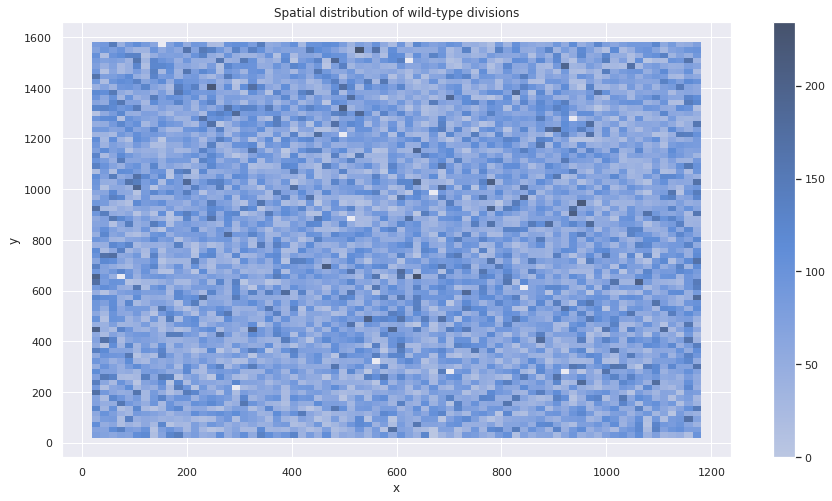

In [112]:
sns.histplot(N_events_df, x = 'x', y = 'y', cbar = True,)
plt.title('Spatial distribution of wild-type divisions')

#### Spatiotemporal distributions

Text(0.5, 1.0, 'Spatio-temporal distribution of wild-type divisions')

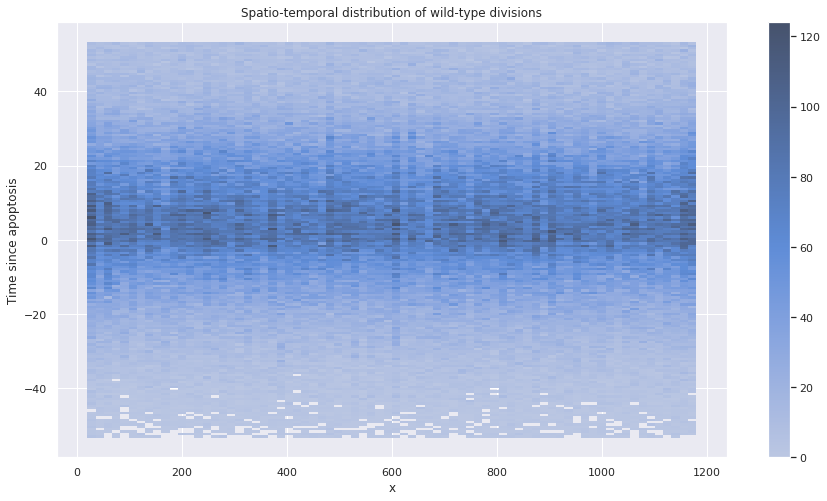

In [113]:
sns.histplot(N_events_df, x = 'x', y = 'Time since apoptosis', cbar = True)
plt.title('Spatio-temporal distribution of wild-type divisions')

Text(0.5, 1.0, 'Spatio-temporal distribution of wild-type divisions')

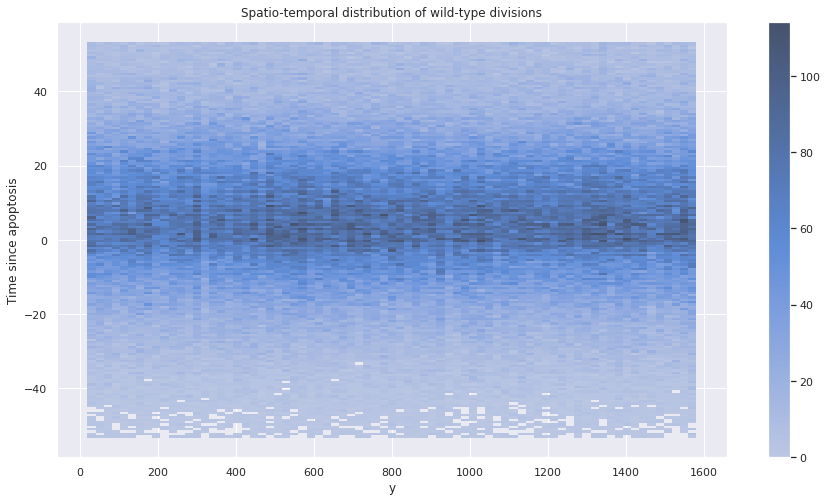

In [114]:
sns.histplot(N_events_df, x = 'y', y = 'Time since apoptosis', cbar = True)
plt.title('Spatio-temporal distribution of wild-type divisions')

Text(0.5, 1.0, 'Spatio-temporal distribution of wild-type divisions')

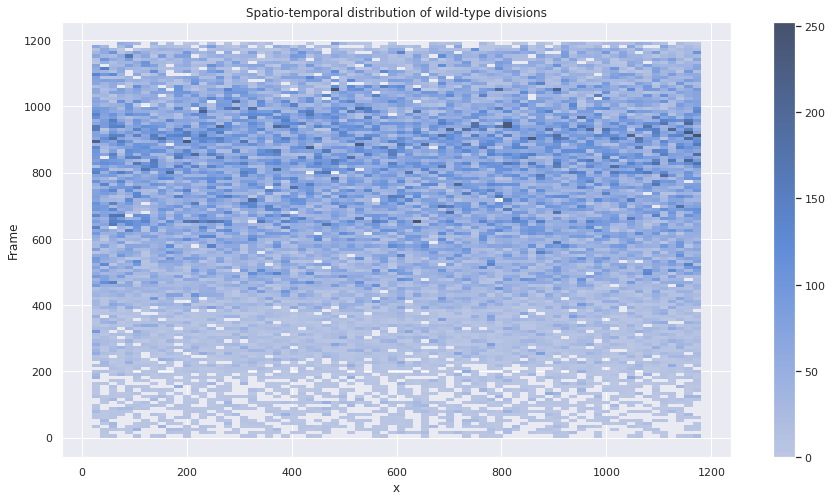

In [115]:
sns.histplot(N_events_df, x = 'x', y = 'Frame', cbar = True)
plt.title('Spatio-temporal distribution of wild-type divisions')

Text(0.5, 1.0, 'Spatio-temporal distribution of wild-type divisions')

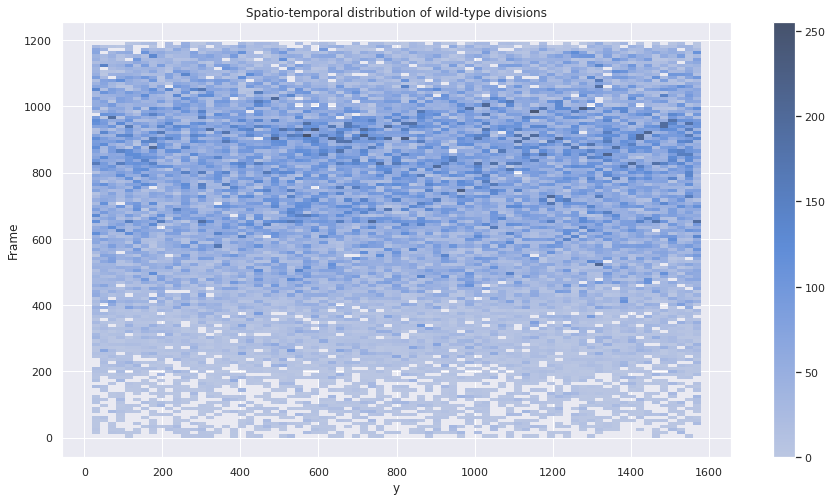

In [116]:
sns.histplot(N_events_df, x = 'y', y = 'Frame', cbar = True)
plt.title('Spatio-temporal distribution of wild-type divisions')

Text(0.5, 1.0, 'Spatio-temporal distribution of wild-type divisions')

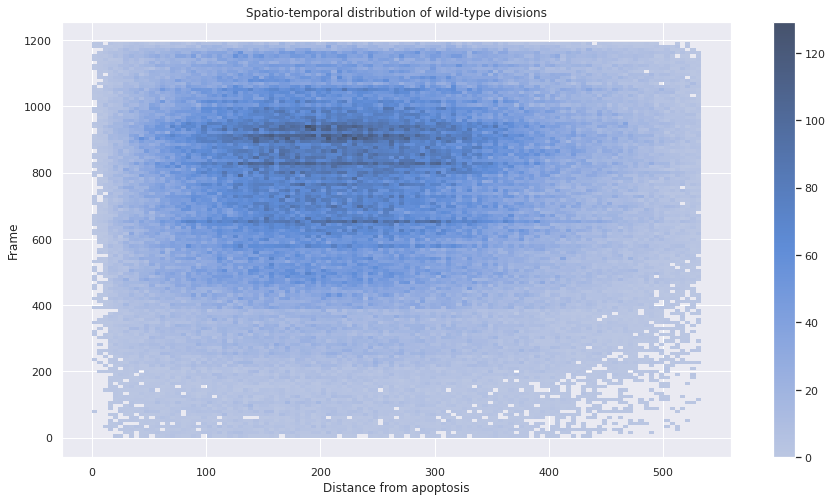

In [117]:
sns.histplot(N_events_df, x = 'Distance from apoptosis', y = 'Frame', cbar = True)
plt.title('Spatio-temporal distribution of wild-type divisions')

### Loading cell counts for probability plot

Has to be streamlined for full list

In [54]:
cell_count_files = [file for file in files if 'N_cell' in file]

In [55]:
cell_count_files

['/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-6_N_cells_wt_rad_1600_t_range_1600_focal_txy_469_692_922.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-70_N_cells_wt_rad_1600_t_range_1600_focal_txy_820_1086_1043.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-73_N_cells_wt_rad_1600_t_range_1600_focal_txy_773_1123_1247.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-283_N_cells_wt_rad_1600_t_range_1600_focal_txy_913_1085_289.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-298_N_cells_wt_rad_1600_t_range_1600_focal_txy_568_404_1103.csv',
 '/home/nathan/data/results/radial_analysis_outp

In [56]:
N_cells_df = load_radial_df(cell_count_files)

  0%|          | 0/1839 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 1025


In [22]:
N_cells_df = load_radial_df(cell_count_files, 
                            R = None, 
                            crop_amount = crop_amount, 
                            streamline = True) ### N_cells is large so streamlining advised

  0%|          | 0/1839 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 1025


In [23]:
N_cells_df

,Distance from apoptosis,Time since apoptosis
0,359.666667,-31.266667
1,358.666667,-31.266667
2,157.666667,-31.266667
3,103.333333,-31.266667
4,110.333333,-31.266667
...,...,...
164112228,329.000000,3.733333
164112229,269.333333,3.733333
164112230,292.666667,3.733333
164112231,400.666667,3.733333


# Plotting the ratio of N_events to N_cells (i.e. P_events) 

These graphs are not cropped or using filtered apoptoses

In [779]:
bins = 40

Text(0.5, 0, 'Time since apoptoses (hours)')

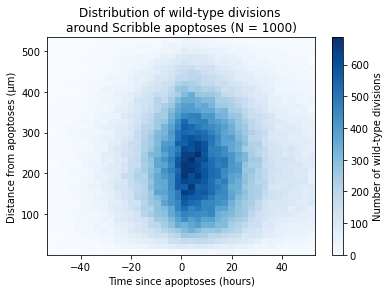

In [780]:
N_events, xedges, yedges, _ = plt.hist2d(N_events_df['Time since apoptosis'], N_events_df['Distance from apoptosis'],
                      bins=bins, cmap='Blues')
plt.colorbar(label = 'Number of wild-type divisions')
plt.title('Distribution of wild-type divisions \naround Scribble apoptoses (N = 1000)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

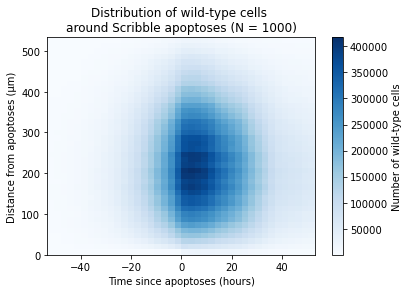

In [781]:
N_cells, xedges, yedges, _ = plt.hist2d(N_cells_df['Time since apoptosis'], N_cells_df['Distance from apoptosis'],
                      bins=bins, cmap='Blues')
plt.colorbar(label = 'Number of wild-type cells')
plt.title('Distribution of wild-type cells \naround Scribble apoptoses (N = 1000)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

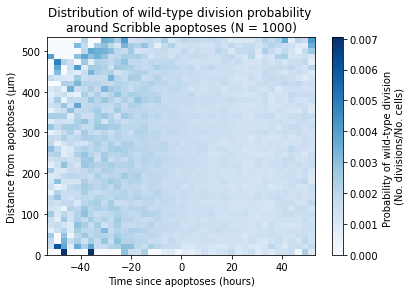

In [798]:
P_events = N_events/N_cells
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Blues')
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)')
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 1000)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

#### Investigating the brightest box 

2 mitosis isn't anything to be going and drawing any conclusions from?

In [790]:
N_events.T[2,0]

2.0

In [793]:
N_cells.T[2,0]

1086.0

In [792]:
N_events.T[2,0]/N_cells[2,0]

0.013888888888888888

# Constraining the spatiotemporal range of the plots

In [820]:
t_min, t_max = -20,20
R_max = 150

In [821]:
bins = 10

In [822]:
N_events_constrained_df = N_events_df.loc[(N_events_df['Time since apoptosis'] >= t_min) & (N_events_df['Time since apoptosis'] <= t_max) & (N_events_df['Distance from apoptosis'] <= R_max)]
N_cells_constrained_df = N_cells_df.loc[(N_cells_df['Time since apoptosis'] >= t_min) & (N_cells_df['Time since apoptosis'] <= t_max) & (N_cells_df['Distance from apoptosis'] <= R_max)]

In [823]:
N_events_constrained_df

,Distance from apoptosis,Time since apoptosis
0,124.666667,-9.800000
1,122.666667,7.133333
2,79.666667,-6.533333
4,134.333333,-6.200000
7,37.333333,-5.000000
...,...,...
228178,103.666667,-5.200000
228180,130.666667,-1.533333
228184,20.666667,1.200000
228186,30.666667,-2.666667


Text(0.5, 0, 'Time since apoptoses (hours)')

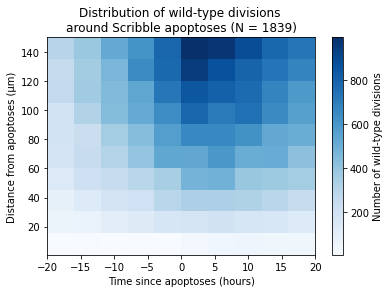

In [824]:
N_events, xedges, yedges, _ = plt.hist2d(N_events_constrained_df['Time since apoptosis'], N_events_constrained_df['Distance from apoptosis'],
                      bins=bins, cmap='Blues')
plt.colorbar(label = 'Number of wild-type divisions')
plt.title('Distribution of wild-type divisions \naround Scribble apoptoses (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

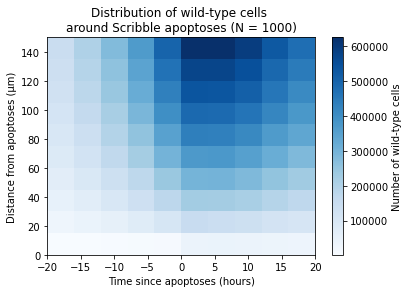

In [825]:
N_cells, xedges, yedges, _ = plt.hist2d(N_cells_constrained_df['Time since apoptosis'], N_cells_constrained_df['Distance from apoptosis'],
                      bins=bins, cmap='Blues')
plt.colorbar(label = 'Number of wild-type cells')
plt.title('Distribution of wild-type cells \naround Scribble apoptoses (N = 1000)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

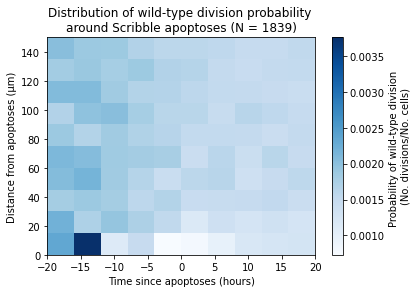

In [826]:
P_events = N_events/N_cells
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Blues')
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Same same kinda graph as before

# Cropping based on radial scan not leaving the FOV

For a radial scan of maximum extent 300 pixels (100um, ie 5 cell radii)

Seeing as we're filtering the scans we can use every radial scan as some will be unused

In [4]:
event_files = [file for file in files if 'N_event' in file]
cell_count_files = [file for file in files if 'N_cell' in file]

In [27]:
crop_amount =20

In [48]:
## maximum size of radial scan in PIXELS 
R = 600

In [49]:
N_events_df = load_radial_df(event_files, 
                            R = R, 
                            crop_amount = crop_amount, 
                            streamline = True)

  0%|          | 0/385 [00:00<?, ?it/s]

ValueError: No objects to concatenate

Text(0.5, 1.0, 'Spatial distribution of filtered Scr. apoptoses (R = 300)')

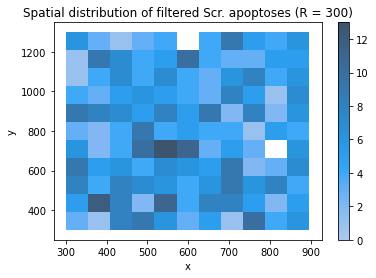

In [16]:
sns.histplot(N_events_apop_xy_df, x = 'x', y = 'y', cbar = True,)
plt.title(f'Spatial distribution of filtered Scr. apoptoses (R = {R})')

In [11]:
N_events_df

,Cell ID,Distance from apoptosis,Frame,x,y,Time since apoptosis
0,23,124.666667,322,569,1311,-9.800000
1,22,122.666667,576,420,673,7.133333
2,21,79.666667,371,486,784,-6.533333
3,20,315.000000,324,391,46,-9.666667
4,19,134.333333,376,416,622,-6.200000
...,...,...,...,...,...,...
138449,1262,154.666667,1036,949,1504,3.533333
138450,1276,272.000000,967,20,1157,-1.066667
138451,1313,109.000000,1033,1107,878,3.333333
138452,1393,235.333333,990,340,1563,0.466667


In [12]:
N_apop_events

642

### Now filter the N_cell counts too

In [47]:
R = 600

In [ ]:
N_events_df = load_radial_df(cell_count_files, 
                            R = R, 
                            crop_amount = crop_amount, 
                            streamline = True)

In [ ]:
N_cells_df = []
N_cells_apop_xy = []
N_apop_cells = 0
for file in tqdm(cell_count_files):
    apo_t, apo_x, apo_y = [int(re.search('txy_(\d+)_(\d+)_(\d+)', file)[i]) for i in range(1,4)]
    ### check if xy falls within range
    if apo_x in x_range and apo_y in y_range:
        df = pd.read_csv(file, names = ['Cell ID', 'Distance from apoptosis', 'Frame', 'x', 'y'])
        ### tidy up dataframe
        df['Cell ID'] = df['Cell ID'].str.replace('[()]', '')
        df['y'] = df['y'].str.replace('[()]', '')
        df = df.astype(int)
        ### normalise time
        df['Time since apoptosis'] = df['Frame'] - apo_t
        ### eliminate boundary counts
        df = df.loc[(df['x'] >= crop_amount) & (df['x'] <= 1200-crop_amount) & (df['y'] >= crop_amount) & (df['y'] <= 1600-crop_amount)]
        N_cells_df.append(df)
        apop_xy = apo_x, apo_y
        N_cells_apop_xy.append(apop_xy)
        N_apop_cells +=1
N_cells_apop_xy_df = pd.DataFrame(N_cells_apop_xy, columns = ['x', 'y'])
N_cells_df = pd.concat(N_cells_df, axis = 0, ignore_index = True)
N_cells_df['Time since apoptosis'] = N_cells_df['Time since apoptosis']*(4/60)
N_cells_df['Distance from apoptosis'] = N_cells_df['Distance from apoptosis']/3

Text(0.5, 1.0, 'Spatial distribution of filtered Scr. apoptoses (R = 300)')

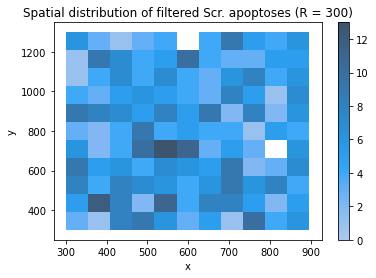

In [17]:
sns.histplot(N_cells_apop_xy_df, x = 'x', y = 'y', cbar = True,)
plt.title(f'Spatial distribution of filtered Scr. apoptoses (R = {R})')

In [18]:
N_cells_df

,Cell ID,Distance from apoptosis,Frame,x,y,Time since apoptosis
0,2,359.666667,0,170,69,-31.266667
1,1,358.666667,0,203,50,-31.266667
2,23,157.666667,0,575,1353,-31.266667
3,22,103.333333,0,536,790,-31.266667
4,21,110.333333,0,537,748,-31.266667
...,...,...,...,...,...,...
99783597,2156,329.000000,1039,841,68,3.733333
99783598,2160,269.333333,1039,76,768,3.733333
99783599,2161,292.666667,1039,603,207,3.733333
99783600,2163,400.666667,1039,155,62,3.733333


In [19]:
N_apop_cells

642

In [20]:
N_apop_cells == N_apop_events

True

# Plotting filtered focal apoptoses

In [21]:
bins = 40

Text(0.5, 0, 'Time since apoptoses (hours)')

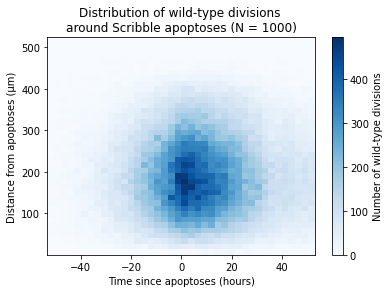

In [22]:
N_events, xedges, yedges, _ = plt.hist2d(N_events_df['Time since apoptosis'], N_events_df['Distance from apoptosis'],
                      bins=bins, cmap='Blues')
plt.colorbar(label = 'Number of wild-type divisions')
plt.title('Distribution of wild-type divisions \naround Scribble apoptoses (N = 1000)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

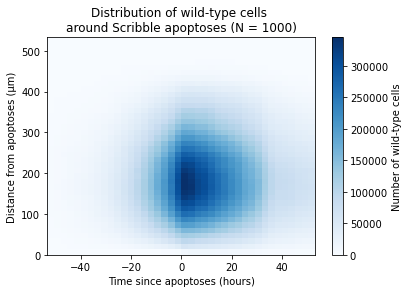

In [23]:
N_cells, xedges, yedges, _ = plt.hist2d(N_cells_df['Time since apoptosis'], N_cells_df['Distance from apoptosis'],
                      bins=bins, cmap='Blues')
plt.colorbar(label = 'Number of wild-type cells')
plt.title('Distribution of wild-type cells \naround Scribble apoptoses (N = 1000)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

<ipython-input-24-79d19a5a34c0>:1: RuntimeWarning: invalid value encountered in true_divide
  P_events = N_events/N_cells


Text(0.5, 0, 'Time since apoptoses (hours)')

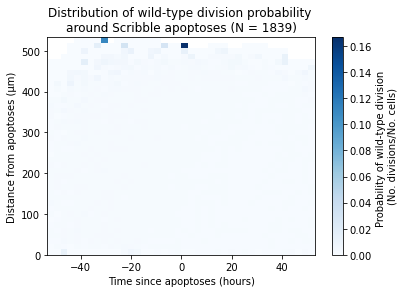

In [24]:
P_events = N_events/N_cells
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Blues')
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

# Constraining the spatiotemporal range of the plots

### This binning is 2hours/25um 

Text(0.5, 0, 'Time since apoptoses (hours)')

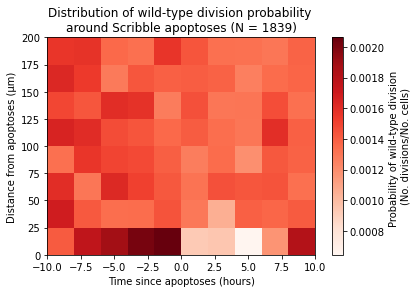

In [610]:
P_events = N_events/N_cells
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Reds',)
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

# Testing different bin sizes

Text(0.5, 0, 'Time since apoptoses (hours)')

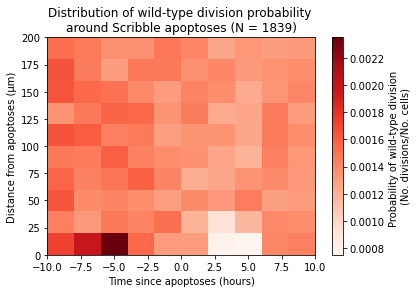

In [57]:
t_range = (-10,10)
R_max = 200
bins = (10, 10)
P_events, xedges, yedges,  N_events, N_cells = render(bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Reds', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

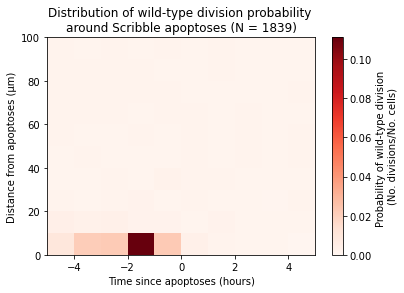

In [47]:
t_range = (-5,5)
R_max = 100
bins = (10, 10)
P_events, xedges, yedges, N_events, N_cells = render(bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Reds', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

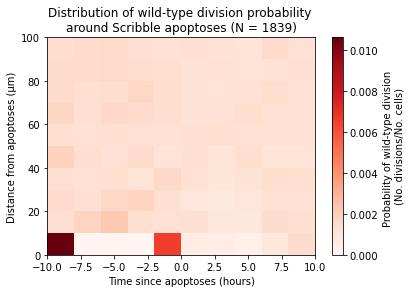

In [48]:
t_range = (-10,10)
R_max = 100
bins = (10, 10)
P_events, xedges, yedges, N_events, N_cells = render(bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Reds', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

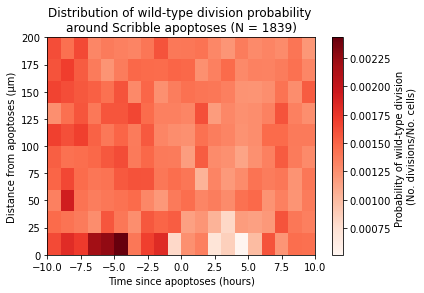

In [60]:
t_range = (-10,10)
R_max = 200
bins = (20, 10)
P_events, xedges, yedges, N_events, N_cells = render(bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Reds', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

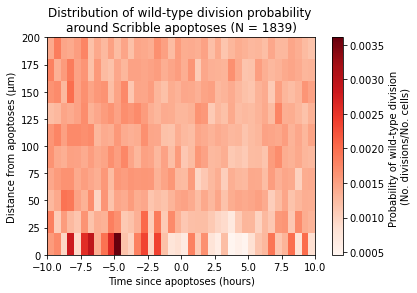

In [61]:
t_range = (-10,10)
R_max = 200
bins = (40, 10)
P_events, xedges, yedges, N_events, N_cells = render(bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Reds', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

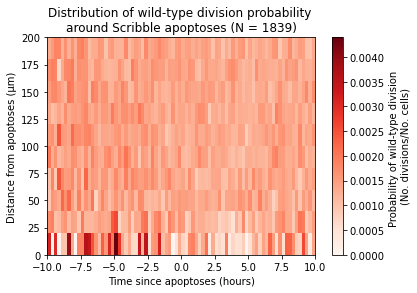

In [63]:
t_range = (-10,10)
R_max = 200
bins = (80, 10)
P_events, xedges, yedges, N_events, N_cells = render(bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Reds', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

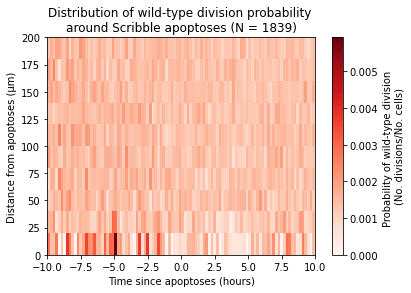

In [64]:
t_range = (-10,10)
R_max = 200
bins = (100, 10)
P_events, xedges, yedges, N_events, N_cells = render(bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Reds', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

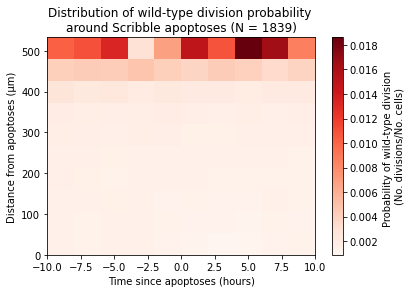

In [54]:
t_range = (-10,10)
R_max = 1000
bins = (10, 10)
P_events, xedges, yedges, N_events, N_cells = render(bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Reds', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

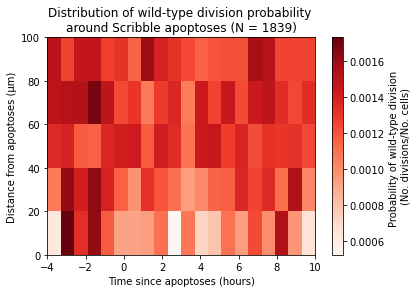

In [35]:
t_range = (-4,10)
R_max = 100
bins = (20, 5)
P_events, xedges, yedges, N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Reds', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

#### Divisions are more homogenously distributed post apoptoses, constraining focal scan plot to post apoptosis

Text(0.5, 0, 'Time since apoptoses (hours)')

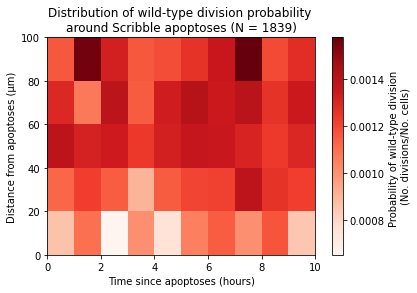

In [37]:
t_range = (0,10)
R_max = 100
bins = (10, 5)
P_events, xedges, yedges, N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Reds', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

# Smooth plot

In [681]:
import scipy.ndimage as sp

#### gaussian filter

Text(0.5, 0, 'Time since apoptoses (hours)')

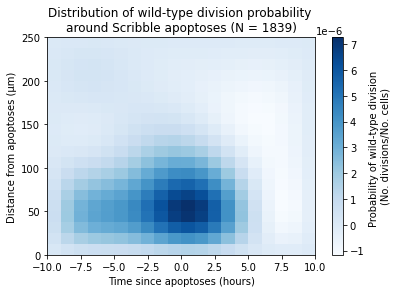

In [686]:
smooth_P_events = sp.filters.gaussian_filter(N_events/N_cells, sigma = 4, order = 1)
pc = plt.pcolormesh(xedges, yedges, smooth_P_events.T, cmap = 'Blues', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

#### contourf

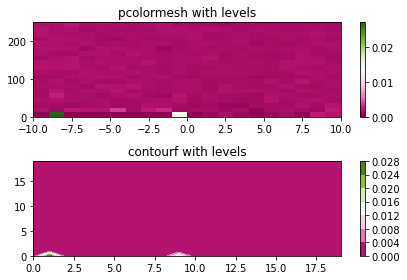

In [690]:
fig, (ax0, ax1) = plt.subplots(nrows=2)
cmap = plt.get_cmap('PiYG')
im = ax0.pcolormesh(xedges, yedges, P_events.T, cmap=cmap, )#norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('pcolormesh with levels')


# contours are *point* based plots, so convert our bound into point
# centers
cf = ax1.contourf(P_events.T, #levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title('contourf with levels')

# adjust spacing between subplots so `ax1` title and `ax0` tick labels
# don't overlap
fig.tight_layout()

plt.show()

In [719]:
from matplotlib.ticker import MaxNLocator

<ipython-input-701-36694c3a0e9d>:14: RuntimeWarning: invalid value encountered in true_divide
  P_events = N_events/N_cells


<Figure size 432x288 with 0 Axes>

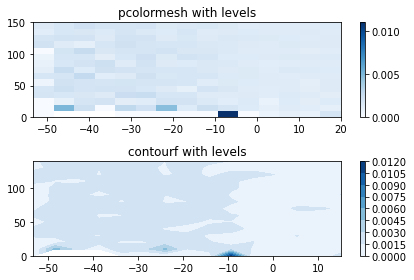

In [720]:
P_events, xedges, yedges = render(bins = (15), t_range = (-60,20), R_max = 150)
fig, (ax0, ax1) = plt.subplots(nrows=2)
cmap = plt.get_cmap('Blues')
im = ax0.pcolormesh(xedges, yedges, P_events.T, cmap=cmap, )#norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('pcolormesh with levels')

levels = MaxNLocator(nbins=15).tick_values(P_events.min(), P_events.max())
# contours are *point* based plots, so convert our bound into point
# centers
cf = ax1.contourf(xedges[0:-1], yedges[0:-1], P_events.T, #levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title('contourf with levels')

# adjust spacing between subplots so `ax1` title and `ax0` tick labels
# don't overlap
fig.tight_layout()

plt.show()

Text(0.5, 0, 'Time since apoptoses (hours)')

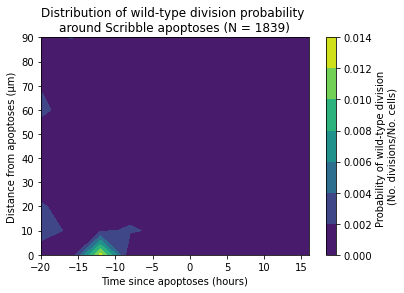

In [729]:
P_events, xedges, yedges = render(bins = (10), t_range = (-20,20), R_max =100)
pc = plt.contourf(xedges[0:-1], yedges[0:-1], P_events.T, cmap = 'viridis', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

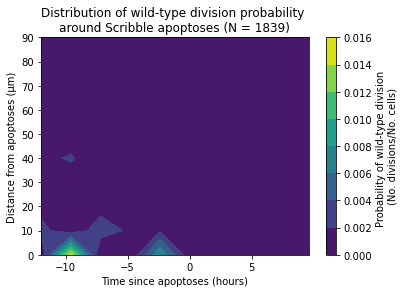

In [731]:
P_events, xedges, yedges = render(bins = (10), t_range = (-12,12), R_max =100)
pc = plt.contourf(xedges[0:-1], yedges[0:-1], P_events.T, cmap = 'viridis', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

## Investigating the number of events in each plot

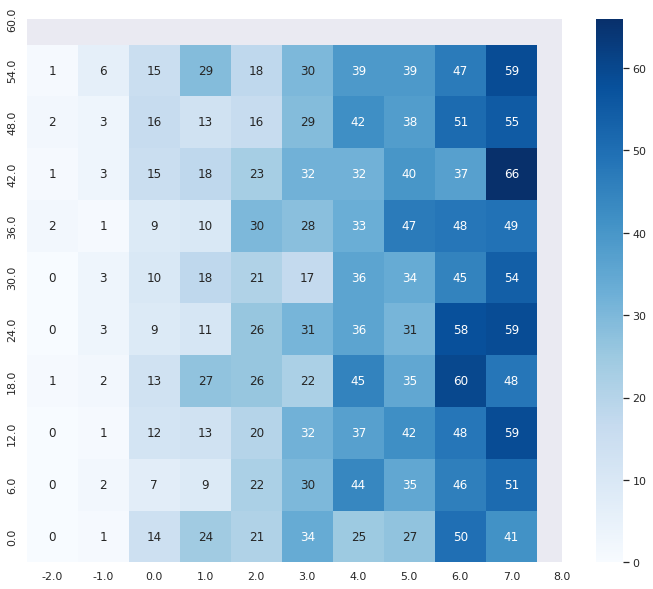

In [140]:
ax = sns.heatmap(N_events, xticklabels=xedges, yticklabels=yedges, cmap = 'Blues', annot= True)
ax.invert_yaxis()

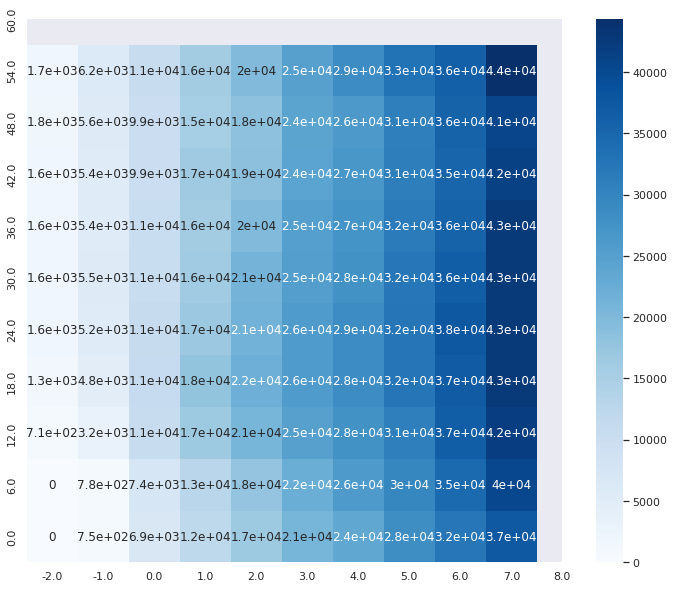

In [141]:
ax = sns.heatmap(N_cells, xticklabels=xedges, yticklabels=yedges, cmap = 'Blues', annot= True)
ax.invert_yaxis()

In [415]:
np.flipud(N_events.T)

array([[ 72.,  93., 136., 174., 217., 276., 392., 430., 456., 461.],
       [ 68.,  65., 103., 152., 185., 245., 351., 470., 402., 429.],
       [ 65.,  97., 111., 149., 186., 253., 317., 386., 375., 404.],
       [ 59.,  78.,  97., 139., 185., 213., 270., 319., 326., 345.],
       [ 43.,  59.,  77.,  99., 139., 164., 220., 254., 251., 265.],
       [ 46.,  46.,  71.,  88., 122., 126., 194., 223., 236., 223.],
       [ 27.,  40.,  47.,  70.,  87., 115., 142., 169., 176., 169.],
       [ 29.,  28.,  25.,  41.,  59.,  80.,  90., 130., 121., 120.],
       [ 12.,  19.,  24.,  32.,  39.,  37.,  61.,  72.,  53.,  77.],
       [  0.,   2.,   3.,   2.,   1.,   4.,  10.,  14.,  12.,  25.]])

# Control measures

### 1. Wild-type divisions around random wild-type points

I have some skepticism about this method as it seems too randomised, leading it to pick up some potential boundary effects of scanning in space and time, i.e. it's suspicious that the peaks in probability are repeated in near pre-apoptotic time.

### 2. Wild-type divisions around wild-type apoptoses

Currently processing this

### 3. Wild-type divisions around Scr. apoptoses in uninduced experiments

Need to find Scr. apoptoses in uninduced experiments.

# Loading control measure #1

In [2]:
files = natsorted(glob.glob(f'/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_control_wt_div_xyt/1600.1600/*.csv'))

In [3]:
files

['/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_control_wt_div_xyt/1600.1600/GV0794_Pos4_wt_4_N_cells_wt_rad_1600_t_range_1600_focal_txy_23_1173_465.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_control_wt_div_xyt/1600.1600/GV0794_Pos4_wt_4_N_events_wt_rad_1600_t_range_1600_focal_txy_23_1173_465.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_control_wt_div_xyt/1600.1600/GV0794_Pos4_wt_5_N_cells_wt_rad_1600_t_range_1600_focal_txy_132_1187_469.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_control_wt_div_xyt/1600.1600/GV0794_Pos4_wt_5_N_events_wt_rad_1600_t_range_1600_focal_txy_132_1187_469.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_control_wt_div_xyt/1600.1600/GV0794_Pos4_wt_7_N_cells_wt_rad_1600_t_range_1600_focal_txy_24_1000_686.csv',
 '/home/nathan/data/results/radial_analysis_output/follo

In [4]:
len(files)

15378

### Limiting the number of control radial scans to include as 15,000 is far too many

Will pick 1839 as that's the same as the previous scans

In [34]:
output_path = f'/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_control_wt_div_xyt/'
radius, t_range = 1600,1600

In [35]:
files = natsorted(glob.glob(f'{output_path}{radius}.{t_range}/*.csv'))[0:(1839*2)]
event_files = [file for file in files if 'N_events' in file]
cell_count_files = [file for file in files if 'N_cells' in file]

In [13]:
for n, i in enumerate((event_files)):
    print(os.path.basename(event_files[n]))
    print(os.path.basename(cell_count_files[n]))

GV0794_Pos4_wt_4_N_events_wt_rad_1600_t_range_1600_focal_txy_23_1173_465.csv
GV0794_Pos4_wt_4_N_cells_wt_rad_1600_t_range_1600_focal_txy_23_1173_465.csv
GV0794_Pos4_wt_5_N_events_wt_rad_1600_t_range_1600_focal_txy_132_1187_469.csv
GV0794_Pos4_wt_5_N_cells_wt_rad_1600_t_range_1600_focal_txy_132_1187_469.csv
GV0794_Pos4_wt_7_N_events_wt_rad_1600_t_range_1600_focal_txy_24_1000_686.csv
GV0794_Pos4_wt_7_N_cells_wt_rad_1600_t_range_1600_focal_txy_24_1000_686.csv
GV0794_Pos4_wt_10_N_events_wt_rad_1600_t_range_1600_focal_txy_66_753_721.csv
GV0794_Pos4_wt_10_N_cells_wt_rad_1600_t_range_1600_focal_txy_66_753_721.csv
GV0794_Pos4_wt_12_N_events_wt_rad_1600_t_range_1600_focal_txy_800_763_873.csv
GV0794_Pos4_wt_12_N_cells_wt_rad_1600_t_range_1600_focal_txy_800_763_873.csv
GV0794_Pos4_wt_14_N_events_wt_rad_1600_t_range_1600_focal_txy_158_609_1344.csv
GV0794_Pos4_wt_14_N_cells_wt_rad_1600_t_range_1600_focal_txy_158_609_1344.csv
GV0794_Pos4_wt_19_N_events_wt_rad_1600_t_range_1600_focal_txy_38_394_779.c

In [18]:
len(event_files)

1839

In [36]:
control_N_event_df = load_radial_df(event_files)

  0%|          | 0/1839 [00:00<?, ?it/s]

<ipython-input-22-a9b9b35c47d7>:22: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Cell ID'] = df['Cell ID'].str.replace('[()]', '')
<ipython-input-22-a9b9b35c47d7>:23: FutureWarning: The default value of regex will change from True to False in a future version.
  df['y'] = df['y'].str.replace('[()]', '')


Number of focal cells included in cumulative scan: 932


In [37]:
control_N_cell_df = load_radial_df(cell_count_files)

  0%|          | 0/1839 [00:00<?, ?it/s]

<ipython-input-22-a9b9b35c47d7>:22: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Cell ID'] = df['Cell ID'].str.replace('[()]', '')
<ipython-input-22-a9b9b35c47d7>:23: FutureWarning: The default value of regex will change from True to False in a future version.
  df['y'] = df['y'].str.replace('[()]', '')


Number of focal cells included in cumulative scan: 932


Text(0.5, 0, 'Time since apoptoses (hours)')

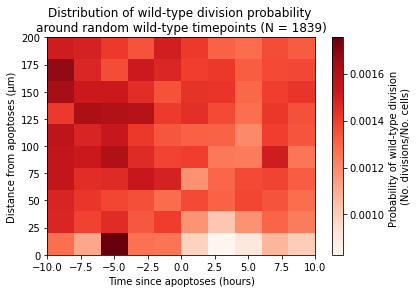

In [38]:
t_range = (-10,10)
R_max = 200
bins = (10, 10)
P_events_c, xedges, yedges,  N_events, N_cells = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Reds', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround random wild-type timepoints (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

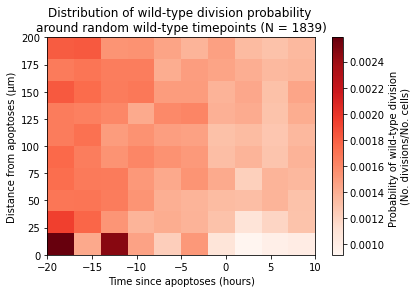

In [43]:
t_range = (-20,10)
R_max = 200
bins = (10, 10)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Reds', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround random wild-type timepoints (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

#### checking against reloaded normal plot

In [27]:
output_path = f'/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/'
radius, t_range = 1600,1600

files = natsorted(glob.glob(f'{output_path}{radius}.{t_range}/*.csv'))[0:(1839*2)]
event_files = [file for file in files if 'N_events' in file]
cell_count_files = [file for file in files if 'N_cells' in file]

In [31]:
N_event_df = load_radial_df(event_files)

N_cell_df = load_radial_df(cell_count_files)

  0%|          | 0/1839 [00:00<?, ?it/s]

<ipython-input-22-a9b9b35c47d7>:22: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Cell ID'] = df['Cell ID'].str.replace('[()]', '')
<ipython-input-22-a9b9b35c47d7>:23: FutureWarning: The default value of regex will change from True to False in a future version.
  df['y'] = df['y'].str.replace('[()]', '')


Number of focal cells included in cumulative scan: 1025


  0%|          | 0/1839 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 1025


Text(0.5, 0, 'Time since apoptoses (hours)')

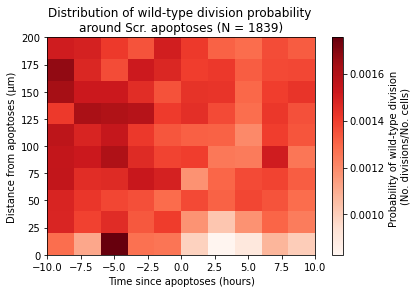

In [50]:
t_range = (-10,10)
R_max = 200
bins = (10, 10)
P_events, xedges, yedges,  N_events, N_cells = render(N_event_df, N_cell_df, bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Reds', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scr. apoptoses (N = 1839)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

## Probability above background

Text(0.5, 0, 'Time since apoptoses (hours)')

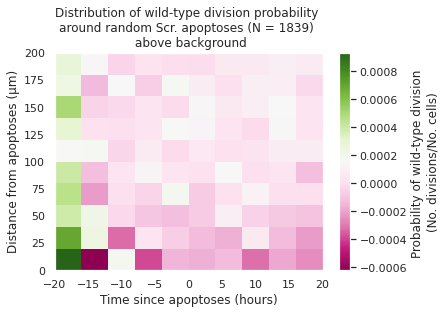

In [160]:
t_range = (-20,20)
R_max = 200
bins = (10, 10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround random Scr. apoptoses (N = 1839) \n above background')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

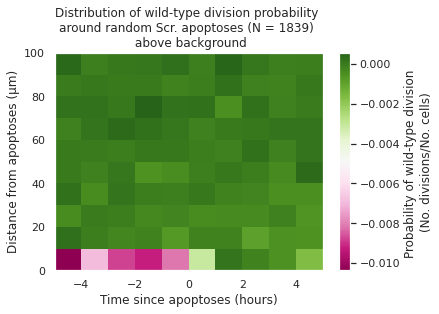

In [161]:
t_range = (-5,5)
R_max = 100
bins = (10, 10)
P_events, xedges, yedges,  N_events, N_cells = render(N_event_df, N_cell_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround random Scr. apoptoses (N = 1839) \n above background')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

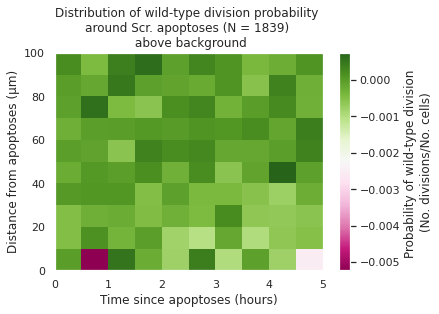

In [162]:
t_range = (0,5)
R_max = 100
bins = (10, 10)
P_events, xedges, yedges,  N_events, N_cells = render(N_event_df, N_cell_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scr. apoptoses (N = 1839) \n above background')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

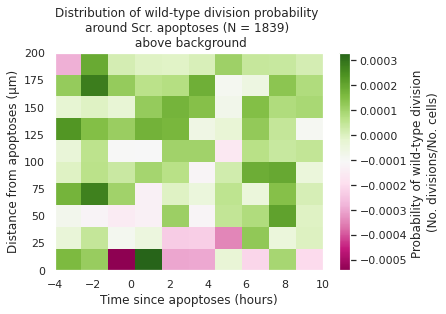

In [163]:
t_range = (-4,10)
R_max = 200
bins = (10, 10)
P_events, xedges, yedges,  N_events, N_cells = render(N_event_df, N_cell_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scr. apoptoses (N = 1839) \n above background')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

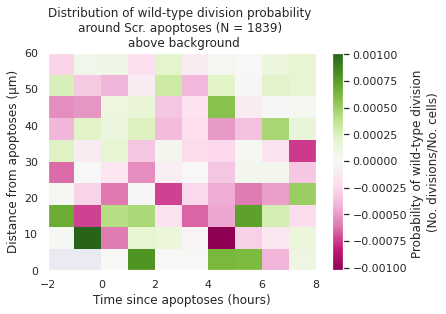

In [164]:
t_range = (-2,8)
R_max = 60
bins = (10, 10)
P_events, xedges, yedges,  N_events, N_cells = render(N_event_df, N_cell_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scr. apoptoses (N = 1839) \n above background')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

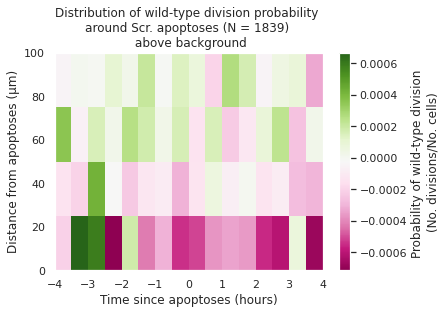

In [167]:
t_range = (-4,4)
R_max = 100
bins = (16, 4)
P_events, xedges, yedges,  N_events, N_cells = render(N_event_df, N_cell_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scr. apoptoses (N = 1839) \n above background')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

# Control measure #2 

### Wild-type divisions around wild-type apoptoses

In [41]:
control_2_file_path = '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600'

In [42]:
files = natsorted(glob.glob(f'{control_2_file_path}/*.csv'))
event_files = [file for file in files if 'N_events' in file]
cell_count_files = [file for file in files if 'N_cells' in file]

In [44]:
len(event_files)

385

In [45]:
control_2_N_events_df = load_radial_df(event_files)

control_2_N_cells_df = load_radial_df(cell_count_files)

  0%|          | 0/385 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 218


  0%|          | 0/385 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 218


Text(0.5, 0, 'Time since apoptoses (hours)')

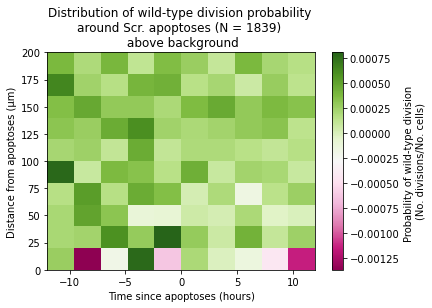

In [58]:
t_range = (-12,12)
R_max = 200
bins = (10,10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scr. apoptoses (N = 1839) \n above background')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

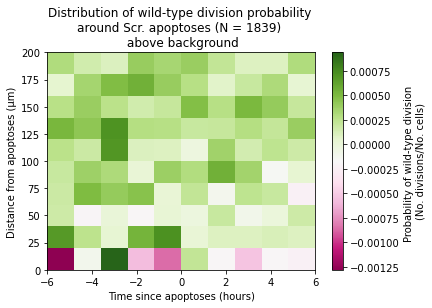

In [59]:
t_range = (-6,6)
R_max = 200
bins = (10,10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scr. apoptoses (N = 1839) \n above background')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

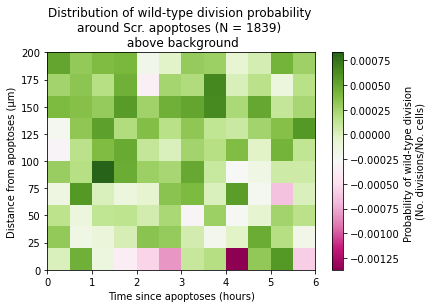

In [60]:
t_range = (0,6)
R_max = 200
bins = (12,10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scr. apoptoses (N = 1839) \n above background')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

#### Trying density plots

In [38]:
N_events_df[0:100]

,Distance from apoptosis,Time since apoptosis
0,124.666667,-9.800000
1,122.666667,7.133333
2,79.666667,-6.533333
3,315.000000,-9.666667
4,134.333333,-6.200000
...,...,...
95,297.000000,23.333333
96,222.333333,27.266667
97,204.000000,19.600000
98,128.666667,27.200000


#### Need to work out way to do ratio of two smoothed density plots

<AxesSubplot:xlabel='Time since apoptosis', ylabel='Distance from apoptosis'>

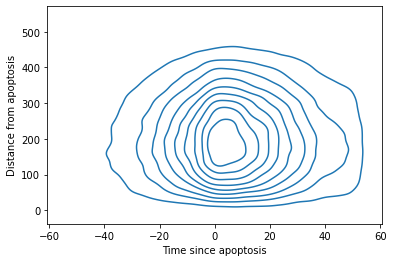

In [39]:
sns.kdeplot(data=N_events_df, x="Time since apoptosis", y="Distance from apoptosis")
